# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

### Set Variables and Paths

In [2]:
# Set Variables
fieldstrength = '3T'
atlas = 'S1000'
bblids = []
sesids = []
nmaps = ["mGluR5", "NMDA","GABA"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)


### Create functions

In [3]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [4]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)

In [5]:
# Correlation matrix
corr_df=heat_df.corr()
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nGross network architecture emerges more strongly in fc+reho\nbut also evident in within-Glu correlations')
#plt.tick_params(axis='both', which='major', labelsize=10)
#plt.show()

### Correlation matrix after masking out the significant ones

In [122]:
#pvals = corr_sig(heat_df)
#mask01 = np.invert(np.tril(pvals<0.01))
#mask001 = np.invert(np.tril(pvals<0.001))

In [115]:
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, mask=mask01, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.001')
#plt.show()

#masked_cestcorr = cestcorr_df.where(pvals <= .0001)

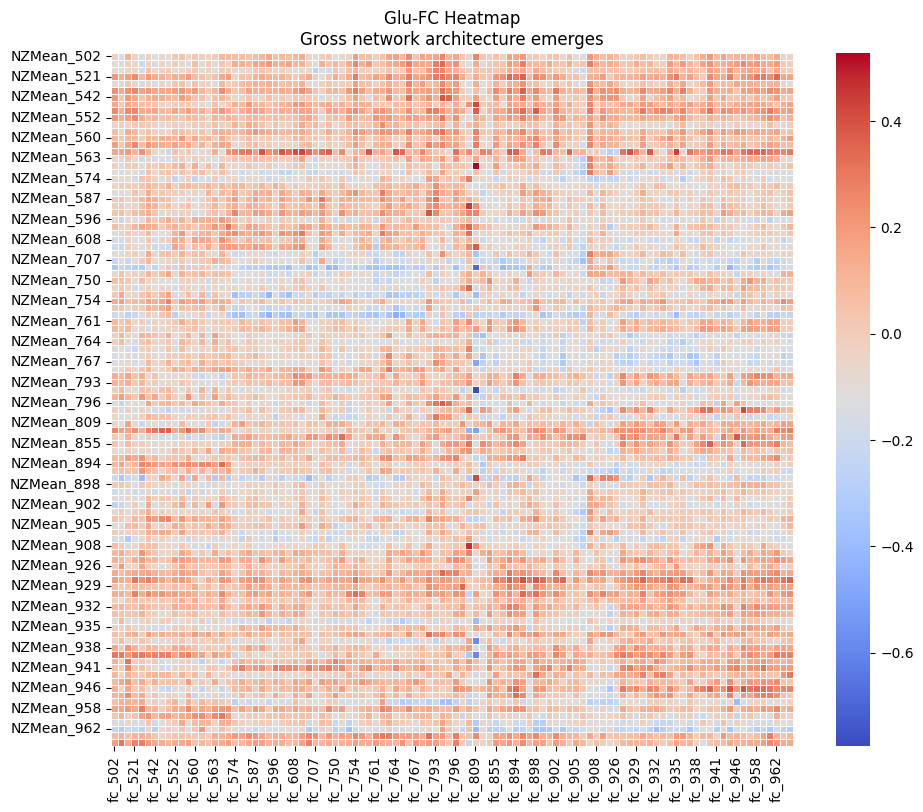

In [6]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

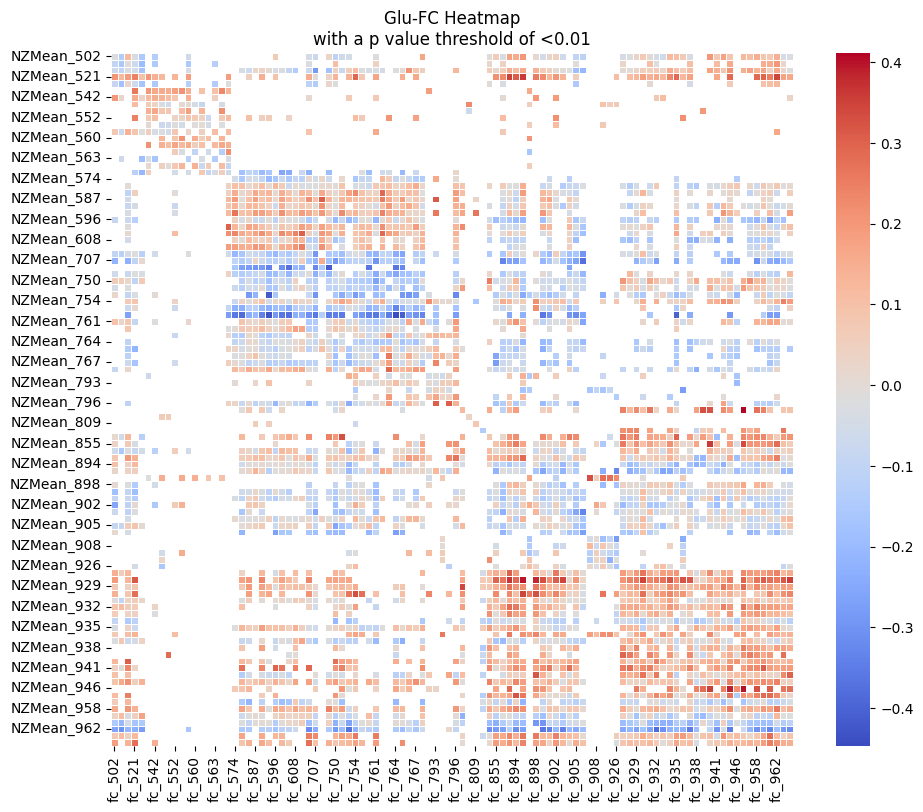

In [7]:
# Keep only signficant values
cestfc = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
pvals = corr_sig(cestfc)
pvals
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.0000001)


plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.01')
plt.show()

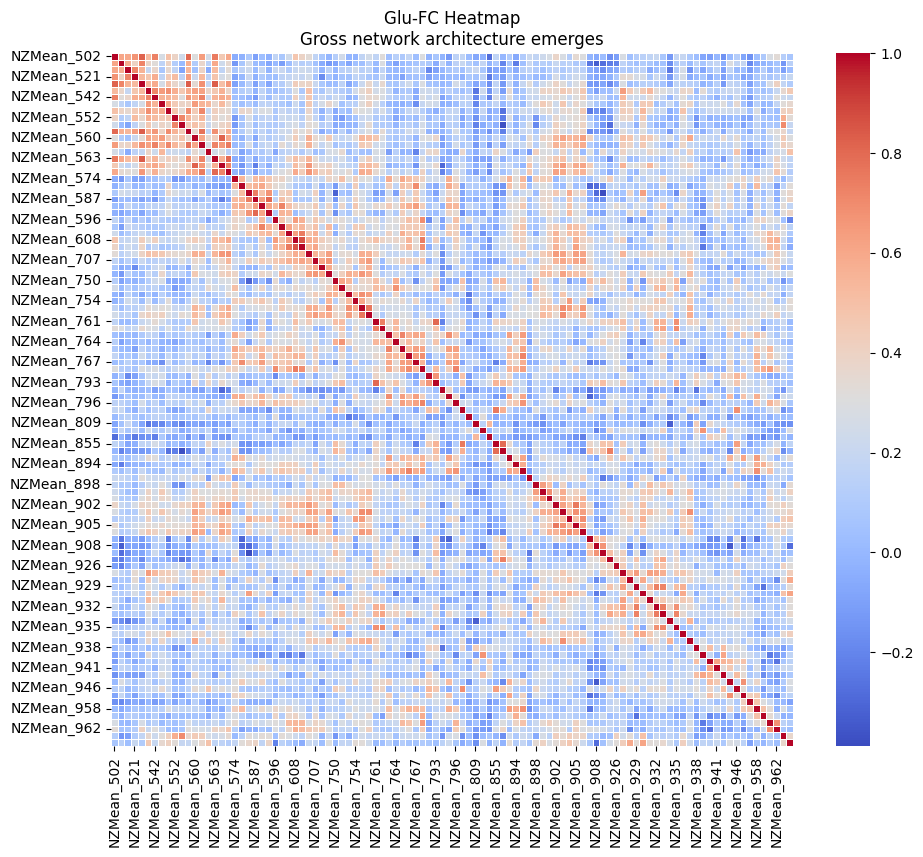

In [112]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

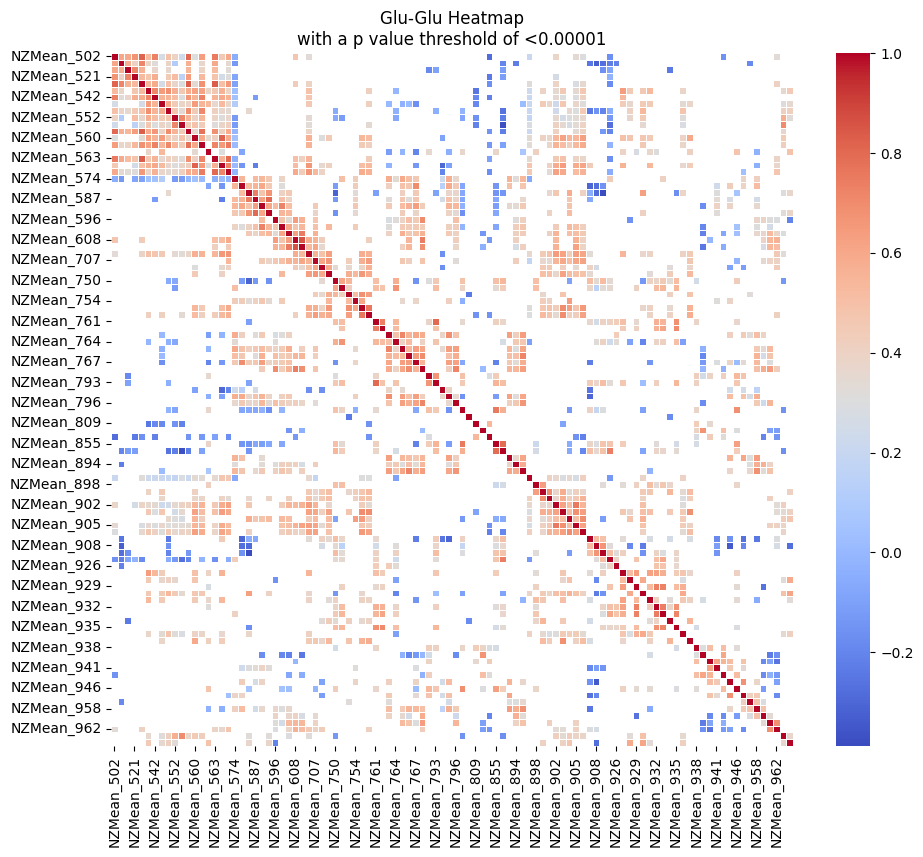

In [103]:
# Keep only signficant values
pvals = corr_sig(cestcorr_df) #

#cestpvals = cestcorr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.00001)

plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-Glu Heatmap\nwith a p value threshold of <0.00001')
plt.show()

### Within- vs between-network

In [8]:
def within_between(corr_df, parcels,symmetric):
    # Returns average correlation within and between network.
    ins = []
    outs = []
    for row in corr_df.index:
        for col in corr_df.columns:
            # Within-network: row and column have to contain parcel names
            if any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    ins.append(corr_df.loc[row, col])
                    
            # Between-network: Only row contains parcel name
            elif any(parcel in row for parcel in parcels) and not any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    outs.append(corr_df.loc[row, col])
            if symmetric == False: # Only run columns with parcel name if corr_df is asymmetric
                if not any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                    if not pd.isna(corr_df.loc[row, col]):
                        outs.append(corr_df.loc[row, col])
    # Run t test comparing within- vs between-network values
    t, p = sp.stats.ttest_ind(ins,outs)
    # Take avg.
    avgin = np.mean(ins)
    sdin = np.std(ins)
    avgout = np.mean(outs)
    sdout = np.std(outs)
    return (avgin, sdin, avgout, sdout, t,p) 

vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

In [9]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(cestcorr_df, vis, True),
    within_between(cestcorr_df, mn, True),
    within_between(cestcorr_df, da, True),
    within_between(cestcorr_df, sn, True),
    within_between(cestcorr_df, lim, True),
    within_between(cestcorr_df, ecn, True),
    within_between(cestcorr_df, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,3.357875e-02,7.486184e-02,-0.177215,-0.031078,-0.044938,-0.033509,7.696920e-02
Within_sd,1.080365e-01,1.007346e-01,0.135831,0.133377,0.197829,0.123778,1.347199e-01
Between_avg,8.031083e-02,-3.531636e-03,-0.103724,-0.037992,0.042382,-0.011320,3.873417e-02
Between_sd,1.193191e-01,1.149599e-01,0.139306,0.130280,0.136657,0.120031,1.309165e-01
t,-6.498262e+00,7.169117e+00,-2.065325,0.946675,-2.447114,-3.001328,6.707202e+00
p,1.044012e-10,1.367758e-12,0.039526,0.343917,0.014823,0.002724,2.398810e-11


In [10]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(masked_cestcorr, vis, True),
    within_between(masked_cestcorr, mn, True),
    within_between(masked_cestcorr, da, True),
    within_between(masked_cestcorr, sn, True),
    within_between(masked_cestcorr, lim, True),
    within_between(masked_cestcorr, ecn, True),
    within_between(masked_cestcorr, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,0.037536,7.486184e-02,-0.177215,-0.032625,0.023756,-0.037321,0.077911
Within_sd,0.111160,1.007346e-01,0.135831,0.135626,0.076868,0.113964,0.134719
Between_avg,0.073398,5.250693e-03,-0.117740,-0.040936,0.109039,-0.013812,0.050009
Between_sd,0.116384,1.105407e-01,0.110585,0.125618,0.115795,0.106234,0.132433
t,-3.801610,6.440311e+00,-2.041302,1.024151,-1.770812,-2.915060,4.391731
p,0.000157,2.095322e-10,0.042267,0.305958,0.079010,0.003627,0.000012


In [11]:
fcdf = pd.DataFrame(zip(
    within_between(cestfc, vis, True),
    within_between(cestfc, mn, True),
    within_between(cestfc, da, True),
    within_between(cestfc, sn, True),
    within_between(cestfc, lim, True),
    within_between(cestfc, ecn, True),
    within_between(cestfc, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
fcdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
fcdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,3.357875e-02,7.486184e-02,-0.177215,-0.031078,-0.044938,-0.033509,7.696920e-02
Within_sd,1.080365e-01,1.007346e-01,0.135831,0.133377,0.197829,0.123778,1.347199e-01
Between_avg,8.031083e-02,-3.531636e-03,-0.103724,-0.037992,0.042382,-0.011320,3.873417e-02
Between_sd,1.193191e-01,1.149599e-01,0.139306,0.130280,0.136657,0.120031,1.309165e-01
t,-6.498262e+00,7.169117e+00,-2.065325,0.946675,-2.447114,-3.001328,6.707202e+00
p,1.044012e-10,1.367758e-12,0.039526,0.343917,0.014823,0.002724,2.398810e-11


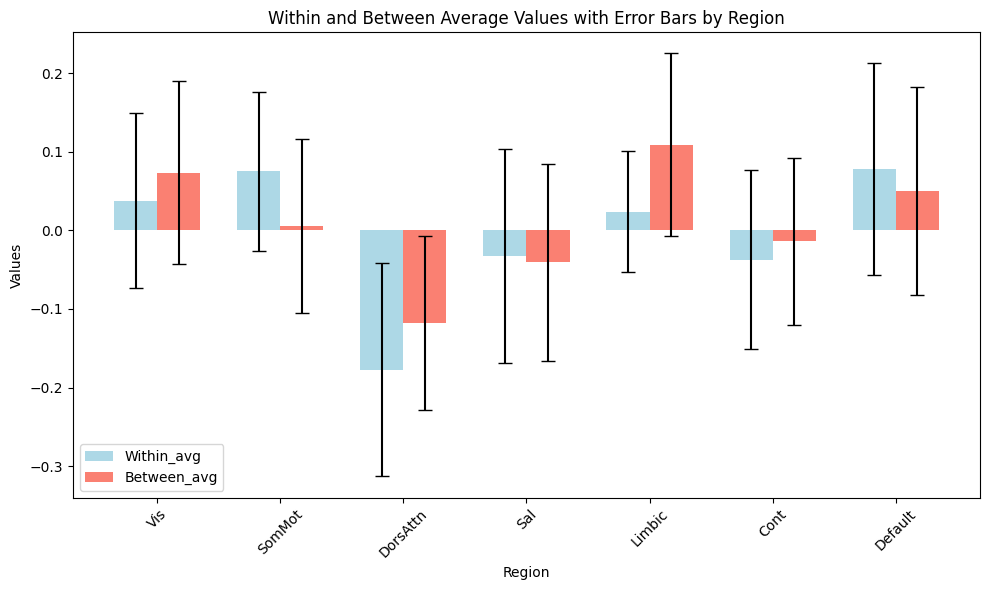

In [12]:
# Make a bar plot comparing within vs between values.
# Extract values
df = cestdf
regions = df.columns
within_avg = df.loc['Within_avg']
within_sd = df.loc['Within_sd']
between_avg = df.loc['Between_avg']
between_sd = df.loc['Between_sd']

# Set positions and width for bars
x = np.arange(len(regions))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot within and between averages with error bars
ax.bar(x - width/2, within_avg, width, yerr=within_sd, label='Within_avg', capsize=5, color='lightblue')
ax.bar(x + width/2, between_avg, width, yerr=between_sd, label='Between_avg', capsize=5,color='salmon')

# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Values')
ax.set_title('Within and Between Average Values with Error Bars by Region')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### NMAP correlations

In [13]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])

mGluR5
r=0.24299725644741313  p=0.013858505052586314
NMDA
r=0.022426387016186256  p=0.8229657832872606
GABA
r=0.5130095803165076  p=3.52877661447222e-08


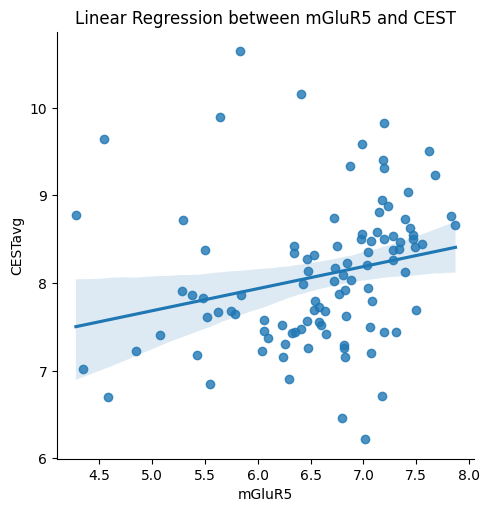

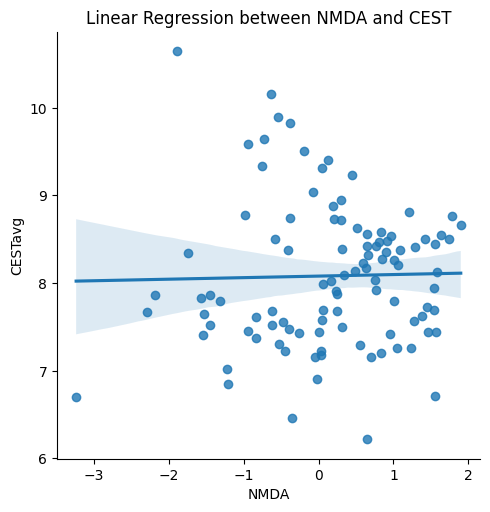

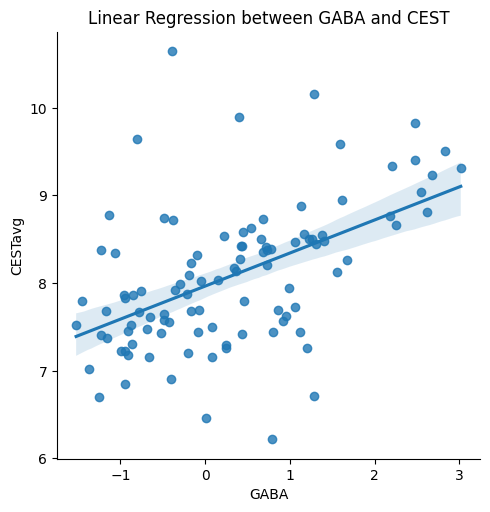

In [14]:
# Loop through nmaps and make correlation plots
# @Maggie, add color by SA axis value.
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(nmap)
    print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 


In [43]:
import statsmodels.api as sm

x=glunmaps[nmaps]
y=glunmaps["CESTavg"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                CESTavg   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     20.42
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           2.34e-10
Time:                        20:23:37   Log-Likelihood:                -98.849
No. Observations:                 102   AIC:                             205.7
Df Residuals:                      98   BIC:                             216.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8104      0.900      9.788      0.0

### Neuromaps correlations by diagnosis

In [ ]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
nmapsdf.columns = nmaps

cestdata = grp_df

In [42]:
from itertools import repeat 
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
nmapsdf.columns = nmaps 
nmapsdf.index = range(1,1001)


# Trim cestmat and keep only the columns with avg values.
df = keep(grp_df, (["NZMean", "hstatus"]))
NC_cestNZMeans = df.loc[:, (df.columns.str.contains("NZMean"))]
NCcestavgs = df[df["hstatus"] == "NC"].filter(like="NZMean").mean(axis=0)
PScestavgs = df[df["hstatus"] != "NC"].filter(like="NZMean").mean(axis=0)
parcels = df.filter(like="NZMean").columns.tolist()


cestdf = pd.DataFrame(
    zip(
        list(repeat("NC", len(NCcestavgs))) + list(repeat("PS", len(PScestavgs))),  # Repeat "NC" and "PS"
        parcels + parcels,  # Parcel names repeated for both NC and PS
        np.concatenate([NCcestavgs.values, PScestavgs.values]),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs)))
    ),  # Concatenate the values for NC and PS
        #np.concatenate([nmap_NC_parcel_values, nmap_PS_parcel_values])  # Concatenate nmap parcel values  
    columns=["hstatus", "parcel", "CESTavg",'mGluR5', 'NMDA', 'GABA']
)

for nmap in nmaps:
    for i in range(501,1001):
        parcel = "NZMean_" + str(i) 
        if parcel in cestdf["parcel"].values:
            cestdf.loc[cestdf["parcel"] == parcel, nmap] = nmapsdf.loc[i, nmap]            

    hstatus      parcel    CESTavg mGluR5 NMDA GABA
0        NC  NZMean_502   9.828479    NaN  NaN  NaN
1        NC  NZMean_504   9.437898    NaN  NaN  NaN
2        NC  NZMean_518  10.497883    NaN  NaN  NaN
3        NC  NZMean_521   9.542822    NaN  NaN  NaN
4        NC  NZMean_532   9.874344    NaN  NaN  NaN
..      ...         ...        ...    ...  ...  ...
199      PS  NZMean_959   7.011228    NaN  NaN  NaN
200      PS  NZMean_961   7.109773    NaN  NaN  NaN
201      PS  NZMean_962   7.451376    NaN  NaN  NaN
202      PS  NZMean_973   8.226691    NaN  NaN  NaN
203      PS  NZMean_974   8.539871    NaN  NaN  NaN

[204 rows x 6 columns]
    hstatus      parcel    CESTavg    mGluR5      NMDA      GABA
0        NC  NZMean_502   9.828479  7.192964 -0.377612  2.481264
1        NC  NZMean_504   9.437898  6.406018 -0.633749  1.279621
2        NC  NZMean_518  10.497883  5.827461 -1.884991 -0.392477
3        NC  NZMean_521   9.542822  6.869866 -0.751941  2.199508
4        NC  NZMean_532   9

'\n\n# Healthy\n# Make new df to store avg nmap values and average CEST values.\nNCglunmaps = nmapsdf.copy()\nNCglunmaps.index = range(1,101)\nNCglunmaps["CESTavg"] = np.nan\n# Add values to new df\nfor i in range(501,1001):\n    cestparcel = f\'NZMean_{i}\'\n    if cestparcel in cestdf["parcel"]:\n        NCglunmaps.loc[i,"CESTavg"] = NCcestavgs["parcel"]\nNCglunmaps = NCglunmaps.dropna(subset=["CESTavg"])\n\n\n\n\n\n\n\n\n# Psychosis\nPScestavgs = PS_cestNZMeans.mean(axis=0)\n# Make new df to store avg nmap values and average CEST values.\nPSglunmaps = nmapsdf.copy()\nPSglunmaps.index = range(1,101)\nPSglunmaps["CESTavg"] = np.nan\n# Add values to new df\nfor i in range(501,1001):\n    cestparcel = f\'NZMean_{i}\'\n    if cestparcel in PScestavgs.index:\n        PSglunmaps.loc[i,"CESTavg"] = PScestavgs[cestparcel]\nPSglunmaps = PSglunmaps.dropna(subset=["CESTavg"])\n\n'

    hstatus      parcel    CESTavg    mGluR5      NMDA      GABA
0        NC  NZMean_502   9.828479  7.192964 -0.377612  2.481264
1        NC  NZMean_504   9.437898  6.406018 -0.633749  1.279621
2        NC  NZMean_518  10.497883  5.827461 -1.884991 -0.392477
3        NC  NZMean_521   9.542822  6.869866 -0.751941  2.199508
4        NC  NZMean_532   9.874344  5.646722 -0.540665  0.404331
..      ...         ...        ...       ...       ...       ...
199      PS  NZMean_959   7.011228  4.345902 -1.215862 -1.375083
200      PS  NZMean_961   7.109773  6.035859 -0.445693 -0.940862
201      PS  NZMean_962   7.451376  5.515342 -0.837716 -0.653351
202      PS  NZMean_973   8.226691  7.340473  0.314567  0.781787
203      PS  NZMean_974   8.539871  7.394060  0.207029  0.682662

[204 rows x 6 columns]


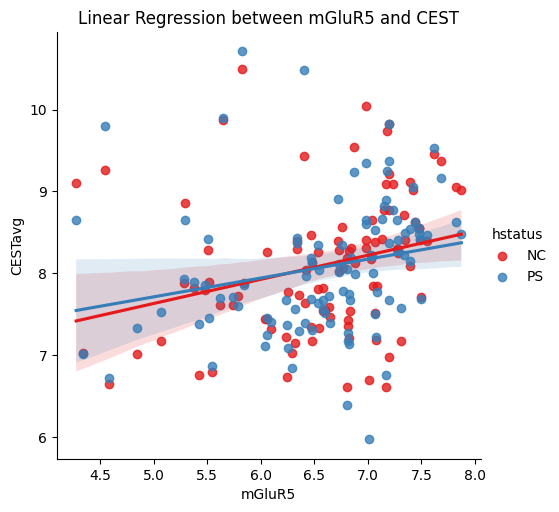

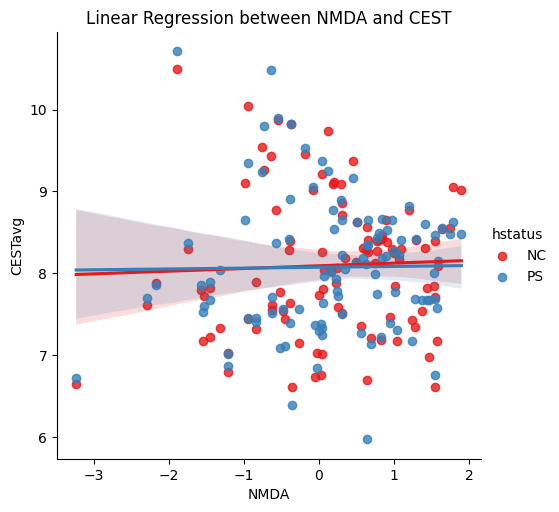

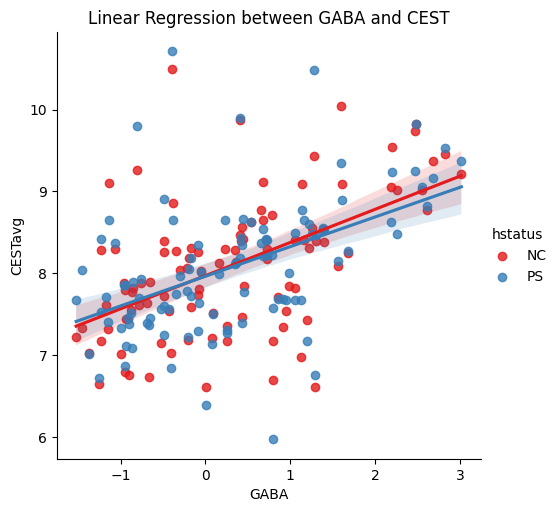

In [49]:
# Loop through nmaps and make correlation plots
print(cestdf)
for nmap in nmaps:
    cestdf[nmap] = pd.to_numeric(cestdf[nmap], errors='coerce')
    cestdf['CESTavg'] = pd.to_numeric(cestdf['CESTavg'], errors='coerce')
    plot_data = cestdf.dropna(subset=[nmap, 'CESTavg'])
    
    plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette="Set1")
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 


In [ ]:
for nmap in nmaps:
    for group in ["PS","NC"]:
        #graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(cestdf[nmap],cestdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))


In [ ]:
receptor_names = np.array(["NMDA","mGluR5","GABAa"])
np.save(path+'data/receptor_names_pet.npy', receptor_names)

# make final region x receptor matrix
receptor_data = np.zeros([nnodes, len(receptor_names)])


# NMDA Data
receptor_data[:, 0] = r[:, 0]


# plot each receptor map
if scale == 'scale1000_17':
    annot = datasets.fetch_schaefer2018('fsaverage')['1000Parcels17Networks']
    type(annot)
    print(annot)
    
    for k in range(len(receptor_names)):
        brain = plotting.plot_fsaverage(data=receptor_data[:, k],
                                        lhannot=annot.lh,
                                        rhannot=annot.rh,
                                        colormap='plasma',
                                        views=['lat', 'med'],
                                        data_kws={'representation': "wireframe"})
        brain.save_image(path+'figures/scale1000_17/surface_receptor_'+receptor_names[k]+'.png')